In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

# Load Input Data:

In [2]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [3]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

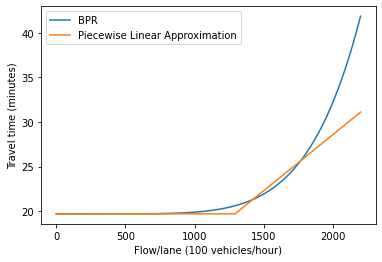

In [4]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [5]:
num_eligible_factor = 3.0

###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v*num_eligible_factor
                               for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.06 (3.5999999999999996 $/hr), 0.72 (43.199999999999996 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 47.400000000000006 $/hr; median: 37.8 $/hr


Text(0, 0.5, '% of population')

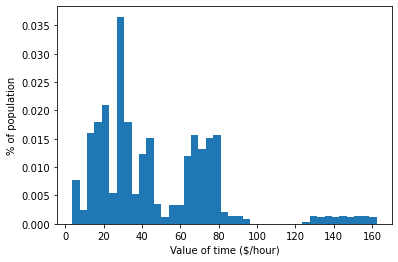

In [6]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

# Define Social Objectives of Interest:

In [7]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.62
18.74
26.49
30.32
37.24
44.05
63.67
68.67
74.8
80.11
162.24


# Solver 1, Budget:

In [8]:
def OptPL_budget(toll, B, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope, is_pure = False):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express lane:
    m1.addConstrs((edge_flows[0, t] == sum(users_in[i, 0, t] for i in range(num_ineligible)) + \
                  users_el[0, t] + sum(users_in[i, 1, t] for i in range(num_ineligible)) + \
                  users_el[1, t] for t in range(T)))
    # Total edge flow, general purpose lane:
    m1.addConstrs((edge_flows[1, t] == sum(users_in[i, 2, t] for i in range(num_ineligible)) + \
                  users_el[2, t] for t in range(T)))
    
    # Non-negativity of all flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(3) for t in range(T)))
    m1.addConstrs((users_in[i, 0, t]==0 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(3) for t in range(T)))
    # Just to compare with original code:
    if is_pure:
        m1.addConstrs((users_el[1, t]==0 for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(3)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(3)) == num_eligible for t in range(T)))
    
    # Budget constraint satisfaction:
    if toll != 0:
        m1.addConstr((sum(toll*users_el[0, t] for t in range(T)) <= B * num_eligible))
        
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    # Set Objective
    m1.setObjective(sum(a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,1,t]/vot_ineligible[i,t] for i in range(num_ineligible))
                        + sum( toll*users_el[1,t]/(vot_eligible[i,t]*num_eligible) for i in range(num_eligible) ) 
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [9]:
def _extract_solution_budget(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 3, T))
    users_el = np.reshape(users_el, (3, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

In [10]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Solve Optimization Problem for Discretized Grid:

## Case 1 - Budget:

In [11]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:]
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) 

# print("tau_arr:\n", tau_arr)
# print()
# print("B_arr:\n", B_arr)

In [12]:
tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
B_arr = np.linspace(0, tau_arr[-1]*4, 9)

print("tau_arr:\n", tau_arr)
print()
print("B_arr:\n", B_arr)

tau_arr:
 [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]

B_arr:
 [ 0. 10. 20. 30. 40. 50. 60. 70. 80.]


In [15]:
t_1 = time.time()

demand_multiplier = [25, 75]

# For saving data:

is_pure = False
# is_pure = True

if is_pure:
    path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data/data_budget_pure/"
else:
    path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data/data_budget/"

row_names = ["Edge flows", "Eps flows", "Eligible User Flows"]
row_names += ["Ineligible User Flow, " + str(k) for k in list(range(num_ineligible + 1))[1:]]

column_names = []
workday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
lane_names = ["Express (Credit)", "Express (Paying)", "General Purpose"]
for workday_index, workday in enumerate(workday_names):
    for lane_index, lane in enumerate(lane_names):
        column_names.append(workday + ", " + lane)
        
## Toll and budget lists:
tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 

## For debugging purposes, truncate tau_arr and B_arr:
# tau_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# B_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# tau_arr = [20]
# tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
# B_arr = np.linspace(0, tau_arr[-1]*4, 9)
# tau_arr = [2.0]
# B_arr = [0.0]


total_count = len(tau_arr) * len(B_arr)

for toll_idx, toll in enumerate(tau_arr):
    for budget_idx, budget in enumerate(B_arr):
        
        if budget >= toll * T or budget == 0 or toll == 0:
            continue
        
        print()
        print("Toll:", toll)
        print("Budget:", budget)
        print()
        
        # Construct optimization problem:
        m_budget = OptPL_budget(toll, budget, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible,  \
                                vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, \
                                fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], \
                                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]), \
                                is_pure = is_pure)

        # Solve optimization problem:
        m_budget.optimize()
        
        print("Optimal solution obtained:", m_budget.status == GRB.OPTIMAL)
        
        # Extract Solution:
        solution_set = _extract_solution_budget(m_budget)
        
        if toll == tau_arr[0]:
            print()
            print("Edge flows:", solution_set["edge_flows"])
            print()
        
        # Storing data:
        data_edge_flows = np.hstack((np.zeros((5, 1)), solution_set["edge_flows"].T)).reshape(15)
        data_eps_flow = np.hstack((np.zeros((5, 1)), solution_set["eps_flows"].T)).reshape(15)
        data_users_el = solution_set["users_el"].T.reshape(15)
        data_users_in = solution_set["users_in"].transpose(0, 2, 1).reshape((num_ineligible, 5*3))
        data = np.vstack((data_edge_flows, data_eps_flow, data_users_el, data_users_in))
        
        if is_pure:
            file_name = path_directory + "toll_" + to_str(toll) + "_budget_pure" + to_str(budget) + ".csv"
        else:
            file_name = path_directory + "toll_" + to_str(toll) + "_budget_" + to_str(budget) + ".csv"
        df = pd.DataFrame(data, columns = column_names, index = row_names)        
        df.to_csv(file_name)


t_2 = time.time()
print("Run time:", t_2 - t_1)


Toll: 2.0
Budget: 5.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xf84a8203
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+03]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.15s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal

Presolve time: 0.15s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.30164463e+09 -4.28835266e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1   7.37489763e+05 -1.33981826e+07  6.36e+03 5.63e-01  1.19e+03     0s
   2   1.18749396e+06 -3.42994334e+06  2.62e+02 2.32e-02  1.06e+02     0s
   3   9.50933958e+05 -4.75458040e+05  3.55e+00 3.15e-04  2.16e+01     0s
   4   9.00099085e+05  7.91052586e+05  1.56e-01 1.38e-05  1.64e+00     0s
   5   8.81399664e+05  8.00921584e+05  5.26e-02 4.66e-06  1.21e+00     0s
   6   8.71095343e+05  8.22700525e+05  2.71e-02 2.40e-06  7.28e-01     0s
   7   8.73024647e+05  8.35056022e+05  1.63e

  14   8.72229016e+05  8.72227804e+05  6.80e-07 1.60e-11  1.82e-05     0s
  15   8.72228722e+05  8.72228073e+05  5.70e-07 7.54e-12  9.75e-06     0s
  16   8.72228548e+05  8.72228230e+05  5.36e-07 2.03e-12  4.77e-06     0s
  17   8.72228429e+05  8.72228345e+05  3.59e-07 5.40e-13  1.26e-06     0s
  18   8.72228391e+05  8.72228380e+05  2.44e-10 2.84e-14  1.64e-07     0s
  19   8.72228386e+05  8.72228386e+05  1.06e-10 7.11e-14  6.62e-09     0s

Barrier solved model in 19 iterations and 0.28 seconds (0.24 work units)
Optimal objective 8.72228386e+05

Optimal solution obtained: True

Toll: 4.0
Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xf8844ff4
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix rang

  16   8.78497433e+05  8.78410105e+05  1.67e-05 1.47e-09  1.31e-03     0s
  17   8.78485319e+05  8.78423189e+05  1.17e-05 1.04e-09  9.35e-04     0s
  18   8.78480386e+05  8.78428766e+05  8.18e-06 7.18e-10  7.77e-04     0s
  19   8.78468885e+05  8.78441130e+05  3.61e-06 3.04e-10  4.18e-04     0s
  20   8.78461260e+05  8.78449148e+05  1.37e-06 1.18e-10  1.82e-04     0s
  21   8.78458758e+05  8.78451765e+05  9.88e-07 6.15e-11  1.05e-04     0s
  22   8.78457087e+05  8.78453504e+05  1.13e-06 2.84e-11  5.39e-05     0s
  23   8.78456045e+05  8.78454587e+05  6.90e-07 7.46e-12  2.19e-05     0s
  24   8.78455489e+05  8.78455156e+05  3.27e-07 1.30e-12  5.00e-06     0s
  25   8.78455353e+05  8.78455294e+05  2.28e-07 1.14e-13  8.82e-07     0s
  26   8.78455325e+05  8.78455322e+05  1.27e-08 5.68e-14  5.15e-08     0s
  27   8.78455324e+05  8.78455324e+05  7.47e-09 8.53e-14  5.16e-10     0s

Barrier solved model in 27 iterations and 0.35 seconds (0.28 work units)
Optimal objective 8.78455324e+05

Opti

  16   8.62489651e+05  8.62486685e+05  3.78e-07 2.72e-12  4.46e-05     0s
  17   8.62488651e+05  8.62487722e+05  2.58e-07 7.74e-13  1.40e-05     0s
  18   8.62488328e+05  8.62488055e+05  2.85e-07 1.71e-13  4.11e-06     0s
  19   8.62488213e+05  8.62488174e+05  9.87e-08 8.53e-14  5.89e-07     0s
  20   8.62488194e+05  8.62488192e+05  4.88e-09 8.53e-14  3.00e-08     0s
  21   8.62488193e+05  8.62488193e+05  3.08e-09 8.53e-14  3.12e-11     0s

Barrier solved model in 21 iterations and 0.34 seconds (0.25 work units)
Optimal objective 8.62488193e+05

Optimal solution obtained: True

Toll: 6.000000000000001
Budget: 5.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x736523cb
Model has 10 quadratic objective terms
Coefficient statistics:


  15   8.73644324e+05  8.73644321e+05  1.89e-08 1.14e-13  4.54e-08     0s
  16   8.73644323e+05  8.73644323e+05  1.82e-10 8.53e-14  4.98e-11     0s

Barrier solved model in 16 iterations and 0.32 seconds (0.22 work units)
Optimal objective 8.73644323e+05

Optimal solution obtained: True

Toll: 6.000000000000001
Budget: 20.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xc114e273
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [2e+00, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.18s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolv

  11   8.67847804e+05  8.50864057e+05  7.83e-03 6.94e-07  2.56e-01     0s
  12   8.63028760e+05  8.54278586e+05  2.96e-03 2.62e-07  1.32e-01     0s
  13   8.60758733e+05  8.56220944e+05  1.37e-03 1.21e-07  6.83e-02     0s
  14   8.59875250e+05  8.57093447e+05  8.18e-04 7.24e-08  4.19e-02     0s
  15   8.58917897e+05  8.58064318e+05  5.36e-05 4.75e-09  1.28e-02     0s
  16   8.58822814e+05  8.58142818e+05  3.62e-05 3.21e-09  1.02e-02     0s
  17   8.58756330e+05  8.58211028e+05  2.89e-05 2.56e-09  8.20e-03     0s
  18   8.58695460e+05  8.58270350e+05  2.24e-05 1.99e-09  6.39e-03     0s
  19   8.58657920e+05  8.58306195e+05  1.85e-05 1.64e-09  5.29e-03     0s
  20   8.58611698e+05  8.58346018e+05  1.20e-05 1.06e-09  4.00e-03     0s
  21   8.58568560e+05  8.58386615e+05  8.16e-06 7.19e-10  2.74e-03     0s
  22   8.58546967e+05  8.58405750e+05  5.66e-06 4.94e-10  2.12e-03     0s
  23   8.58528418e+05  8.58423123e+05  4.13e-06 3.65e-10  1.58e-03     0s
  24   8.58519177e+05  8.58431319e+05 

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.04829782e+09 -4.27743730e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -8.26753029e+05 -1.34489337e+07  6.36e+03 5.64e-01  1.19e+03     0s
   2   1.23960022e+06 -3.17503421e+06  1.45e+02 1.29e-02  8.73e+01     0s
   3   1.01444954e+06 -4.98490476e+05  1.26e+00 1.12e-04  2.28e+01     0s
   4   9.57557320e+05  6.63409048e+05  2.29e-01 2.03e-05  4.43e+00     0s
   5   9.40449432e+05  6.49926777e+05  2.21e-01 1.96e-05  4.37e+00     0s
   6   9.14443681e+05  6.95466969e+05  2.21e-07 1.96e-11  3.29e+00     0s
   7   8.92403327e+05  8.60598940e+05  1.08e-08 4.48e-13  4.78e-01     0s
   8   8.81972914e+05  8.77455033e+05  1.15e-08 8.53e-14  6.80e-02     0s
   9   8.7991885

   0  -3.04834536e+09 -4.27744356e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -8.76207463e+05 -1.34130782e+07  6.39e+03 5.66e-01  1.20e+03     0s
   2   1.16524063e+06 -3.37175065e+06  2.94e+02 2.60e-02  1.11e+02     0s
   3   1.02663170e+06 -7.80352237e+05  4.71e+00 4.17e-04  2.75e+01     0s
   4   9.56469077e+05  6.51167992e+05  7.27e-01 6.44e-05  4.61e+00     0s
   5   9.23942421e+05  6.27363536e+05  6.51e-01 5.77e-05  4.48e+00     0s
   6   8.88149746e+05  8.08296555e+05  6.81e-03 6.03e-07  1.20e+00     0s
   7   8.83882198e+05  8.32527801e+05  2.94e-03 2.61e-07  7.73e-01     0s
   8   8.71455573e+05  8.53232744e+05  7.74e-04 6.85e-08  2.74e-01     0s
   9   8.67227711e+05  8.59668412e+05  3.03e-04 2.68e-08  1.14e-01     0s
  10   8.66032646e+05  8.61383815e+05  1.48e-04 1.31e-08  6.99e-02     0s
  11   8.65360433e+05  8.62244062e+05  8.94e-05 7.92e-09  4.69e-02     0s
  12   8.64799187e+05  8.62976889e+05  5.06e-05 4.48e-09  2.74e-02     0s
  13   8.64550816e+05  8.63282949e+05 

  13   8.95947691e+05  8.95944921e+05  1.04e-06 4.79e-11  4.17e-05     0s
  14   8.95946937e+05  8.95945618e+05  5.84e-07 1.89e-11  1.98e-05     0s
  15   8.95946499e+05  8.95946032e+05  4.11e-07 6.42e-12  7.02e-06     0s
  16   8.95946399e+05  8.95946124e+05  5.21e-06 1.29e-12  4.10e-06     0s
  17   8.95946293e+05  8.95946225e+05  2.73e-07 1.71e-13  1.03e-06     0s
  18   8.95946259e+05  8.95946259e+05  2.92e-09 1.14e-13  1.84e-09     0s

Barrier solved model in 18 iterations and 0.26 seconds (0.23 work units)
Optimal objective 8.95946259e+05

Optimal solution obtained: True

Toll: 8.0
Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x487fddb2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix rang


Barrier solved model in 16 iterations and 0.25 seconds (0.22 work units)
Optimal objective 8.79797785e+05

Optimal solution obtained: True

Toll: 8.0
Budget: 25.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x6ca953cf
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [3e+00, 4e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.13s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Fac

  17   8.64814680e+05  8.64197319e+05  4.72e-06 4.04e-10  9.29e-03     0s
  18   8.64740752e+05  8.64274686e+05  3.56e-06 3.04e-10  7.01e-03     0s
  19   8.64687646e+05  8.64329217e+05  2.72e-06 2.32e-10  5.39e-03     0s
  20   8.64650751e+05  8.64366730e+05  2.17e-06 1.83e-10  4.27e-03     0s
  21   8.64622298e+05  8.64395329e+05  1.74e-06 1.46e-10  3.41e-03     0s
  22   8.64602418e+05  8.64415224e+05  1.44e-06 1.20e-10  2.82e-03     0s
  23   8.64582518e+05  8.64434859e+05  1.11e-06 9.43e-11  2.22e-03     0s
  24   8.64565722e+05  8.64451212e+05  1.15e-06 7.29e-11  1.72e-03     0s
  25   8.64553103e+05  8.64463429e+05  1.05e-06 5.68e-11  1.35e-03     0s
  26   8.64544863e+05  8.64471409e+05  5.28e-07 4.64e-11  1.10e-03     0s
  27   8.64537669e+05  8.64478356e+05  4.43e-07 3.74e-11  8.92e-04     0s
  28   8.64530813e+05  8.64484928e+05  7.42e-07 2.88e-11  6.90e-04     0s
  29   8.64527339e+05  8.64488158e+05  6.27e-07 2.26e-11  5.89e-04     0s
  30   8.64521357e+05  8.64493888e+05 

   3   1.03390714e+06 -1.30900177e+04  1.59e+00 1.41e-04  1.58e+01     0s
   4   9.80579655e+05  5.30812283e+05  6.22e-01 5.51e-05  6.78e+00     0s
   5   9.48499045e+05  6.01036417e+05  2.97e-01 2.63e-05  5.23e+00     0s
   6   9.20738487e+05  8.08676744e+05  2.20e-03 1.95e-07  1.69e+00     0s
   7   9.00213093e+05  8.74752962e+05  3.88e-04 3.44e-08  3.83e-01     0s
   8   8.93391946e+05  8.87923648e+05  4.96e-05 4.40e-09  8.23e-02     0s
   9   8.91074726e+05  8.89978411e+05  5.88e-06 5.21e-10  1.65e-02     0s
  10   8.90591961e+05  8.90482107e+05  2.18e-07 1.92e-11  1.65e-03     0s
  11   8.90553791e+05  8.90522954e+05  4.67e-08 3.74e-12  4.64e-04     0s
  12   8.90543664e+05  8.90533663e+05  4.26e-07 1.02e-12  1.50e-04     0s
  13   8.90541568e+05  8.90535862e+05  7.01e-07 5.12e-13  8.58e-05     0s
  14   8.90539675e+05  8.90537839e+05  3.12e-07 1.14e-13  2.76e-05     0s
  15   8.90539179e+05  8.90538347e+05  4.21e-07 1.14e-13  1.25e-05     0s
  16   8.90538828e+05  8.90538707e+05 

   8   8.78471452e+05  8.70777696e+05  6.09e-08 1.21e-13  1.16e-01     0s
   9   8.77080244e+05  8.72465412e+05  9.44e-08 7.11e-14  6.94e-02     0s
  10   8.76292899e+05  8.73386670e+05  1.04e-07 1.14e-13  4.37e-02     0s
  11   8.75673078e+05  8.74071391e+05  2.72e-08 5.68e-14  2.41e-02     0s
  12   8.75154507e+05  8.74599329e+05  1.86e-08 1.14e-13  8.35e-03     0s
  13   8.74960062e+05  8.74786715e+05  4.39e-08 1.14e-13  2.61e-03     0s
  14   8.74913209e+05  8.74831288e+05  2.56e-07 1.14e-13  1.23e-03     0s
  15   8.74891428e+05  8.74852002e+05  3.50e-07 1.14e-13  5.93e-04     0s
  16   8.74879544e+05  8.74863358e+05  8.04e-07 1.14e-13  2.43e-04     0s
  17   8.74873036e+05  8.74869605e+05  4.14e-07 1.14e-13  5.16e-05     0s
  18   8.74871847e+05  8.74870758e+05  4.32e-07 1.14e-13  1.64e-05     0s
  19   8.74871363e+05  8.74871230e+05  1.03e-07 1.71e-13  1.99e-06     0s
  20   8.74871297e+05  8.74871296e+05  5.45e-10 1.71e-13  1.54e-08     0s
  21   8.74871296e+05  8.74871296e+05 

  31   8.65003155e+05  8.65003155e+05  2.71e-09 1.14e-13  1.90e-10     0s

Barrier solved model in 31 iterations and 0.48 seconds (0.31 work units)
Optimal objective 8.65003155e+05

Optimal solution obtained: True

Toll: 10.0
Budget: 5.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x647b5188
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+03]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.23s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA'

  16   8.95804579e+05  8.95804579e+05  4.12e-10 1.71e-13  6.05e-11     0s

Barrier solved model in 16 iterations and 0.30 seconds (0.22 work units)
Optimal objective 8.95804579e+05

Optimal solution obtained: True

Toll: 10.0
Budget: 20.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x835b8b26
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.17s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA

Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 5e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.16s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.35832018e+09 -4.26925190e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -2.05002459e+06 -1.34138947e+07  6.39e+03 5.66e-01  1.20e+03     0s
   2   1.22602502e+06 -3.15893523e+06  1.85e+02 1.64e-02  9.32e+01     0s
   3   1.05514746e+06 -2.95300292e+05  2.55e+00 2.26e-04  2.

   5   9.14143620e+05  7.51821988e+05  1.07e-01 9.47e-06  2.44e+00     0s
   6   8.95364092e+05  7.87285506e+05  5.76e-02 5.10e-06  1.63e+00     0s
   7   8.81977044e+05  8.29022266e+05  5.85e-08 5.11e-12  7.97e-01     0s
   8   8.70607365e+05  8.57300262e+05  1.36e-08 9.52e-13  2.00e-01     0s
   9   8.67591109e+05  8.62103315e+05  1.46e-08 3.41e-13  8.25e-02     0s
  10   8.65803164e+05  8.65134390e+05  6.31e-08 1.14e-13  1.01e-02     0s
  11   8.65768897e+05  8.65156263e+05  5.40e-08 1.14e-13  9.22e-03     0s
  12   8.65690352e+05  8.65216513e+05  1.55e-07 1.14e-13  7.13e-03     0s
  13   8.65625622e+05  8.65273866e+05  1.21e-07 1.14e-13  5.29e-03     0s
  14   8.65576071e+05  8.65316313e+05  1.60e-07 1.14e-13  3.91e-03     0s
  15   8.65544352e+05  8.65343394e+05  1.55e-07 1.14e-13  3.02e-03     0s
  16   8.65524177e+05  8.65358987e+05  3.88e-07 1.14e-13  2.48e-03     0s
  17   8.65501795e+05  8.65376895e+05  2.07e-07 1.14e-13  1.88e-03     0s
  18   8.65480647e+05  8.65395410e+05 

   2   1.29710015e+06 -3.06446399e+06  1.15e+02 1.02e-02  8.26e+01     0s
   3   1.06430270e+06 -7.40255875e+04  3.00e+00 2.66e-04  1.73e+01     0s
   4   1.00260710e+06  5.00195707e+05  1.20e+00 1.06e-04  7.60e+00     0s
   5   9.63875692e+05  6.13679868e+05  4.93e-01 4.36e-05  5.28e+00     0s
   6   9.26707501e+05  8.32016626e+05  4.94e-07 4.37e-11  1.42e+00     0s
   7   9.05938993e+05  8.95392502e+05  1.98e-08 1.54e-12  1.59e-01     0s
   8   9.01443033e+05  9.00405204e+05  8.38e-10 1.71e-13  1.56e-02     0s
   9   9.00998757e+05  9.00775752e+05  2.72e-09 1.14e-13  3.35e-03     0s
  10   9.00900474e+05  9.00872376e+05  4.78e-09 1.14e-13  4.23e-04     0s
  11   9.00888239e+05  9.00884548e+05  2.11e-08 1.71e-13  5.55e-05     0s
  12   9.00886661e+05  9.00886123e+05  7.44e-08 1.71e-13  8.09e-06     0s
  13   9.00886398e+05  9.00886386e+05  1.13e-07 1.71e-13  1.84e-07     0s
  14   9.00886393e+05  9.00886391e+05  5.70e-09 1.14e-13  1.94e-08     0s
  15   9.00886392e+05  9.00886392e+05 

  14   8.85173346e+05  8.85167688e+05  2.49e-07 1.14e-13  8.51e-05     0s
  15   8.85171546e+05  8.85169413e+05  3.88e-07 1.14e-13  3.21e-05     0s
  16   8.85170526e+05  8.85170400e+05  1.15e-08 1.71e-13  1.91e-06     0s
  17   8.85170471e+05  8.85170454e+05  3.96e-09 1.71e-13  2.55e-07     0s
  18   8.85170463e+05  8.85170463e+05  7.29e-10 1.71e-13  3.88e-09     0s

Barrier solved model in 18 iterations and 0.30 seconds (0.23 work units)
Optimal objective 8.85170463e+05

Optimal solution obtained: True

Toll: 11.0
Budget: 35.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x96ffa82d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 5e+01]
  QObjective range

 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.79501284e+09 -4.26652429e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -2.47311269e+06 -1.33775902e+07  6.41e+03 5.68e-01  1.20e+03     0s
   2   1.19902825e+06 -3.18062788e+06  2.18e+02 1.93e-02  9.82e+01     0s
   3   1.07336014e+06 -4.07912135e+05  3.06e+00 2.71e-04  2.25e+01     0s
   4   1.00129944e+06  4.67066541e+05  9.85e-01 8.72e-05  8.07e+00     0s
   5   9.20526826e+05  7.67379938e+05  2.92e-02 2.59e-06  2.30e+00     0s
   6   8.95225273e+05  8.11192402e+05  1.73e-03 1.53e-07  1.26e+00     0s
   7   8.81403487e+05  8.52016667e+05  5.00e-04 4.43e-08  4.42e-01     0s
   8   8.73413298e+05  8.65460520e+05  9.03e-05 8.00e-09  1.20e-01     0s
   9   8.71736479e+05  8.68383447e+05  3.60e-05 3.17e-09  5.04e-02     0s
  10   8.71455343e+05  8.68750968e+05  2.89e-05 2.55e-09  

 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.23157502e+09 -4.26378614e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -2.75241532e+06 -1.30883779e+07  6.36e+03 5.63e-01  1.19e+03     0s
   2   1.31281415e+06 -3.05086784e+06  1.13e+02 1.00e-02  8.25e+01     0s
   3   1.08454494e+06 -6.50126823e+04  1.08e+01 9.53e-04  1.79e+01     0s
   4   1.02006965e+06  4.69048677e+05  4.76e+00 4.22e-04  8.46e+00     0s
   5   9.93425608e+05  4.86895812e+05  1.93e+00 1.71e-04  7.69e+00     0s
   6   9.50167279e+05  7.65309610e+05  1.93e-06 1.71e-10  2.78e+00     0s
   7   9.24351405e+05  8.87912838e+05  3.30e-07 2.92e-11  5.48e-01     0s
   8   9.13703149e+05  9.08478240e+05  2.49e-08 1.02e-12  7.86e-02     0s
   9   9.11463049e+05  9.10783838e+05  7.20e-09 1.71e-13  

   4   1.01259368e+06  4.46728304e+05  5.79e-01 5.13e-05  8.53e+00     0s
   5   9.71349049e+05  5.47770155e+05  3.03e-01 2.68e-05  6.38e+00     0s
   6   9.37619690e+05  7.71116486e+05  3.03e-07 2.68e-11  2.50e+00     0s
   7   9.11201303e+05  8.66970127e+05  6.34e-08 4.29e-12  6.65e-01     0s
   8   9.01385145e+05  8.86695835e+05  4.12e-08 1.08e-12  2.21e-01     0s
   9   8.97356117e+05  8.92994223e+05  1.90e-08 2.56e-13  6.56e-02     0s
  10   8.95540649e+05  8.94921596e+05  8.49e-09 1.71e-13  9.31e-03     0s
  11   8.95304233e+05  8.95189343e+05  8.33e-09 1.71e-13  1.73e-03     0s
  12   8.95252594e+05  8.95245986e+05  2.58e-09 1.71e-13  9.94e-05     0s
  13   8.95249771e+05  8.95248892e+05  6.41e-08 1.71e-13  1.32e-05     0s
  14   8.95249400e+05  8.95249272e+05  1.52e-06 1.71e-13  1.91e-06     0s
  15   8.95249342e+05  8.95249330e+05  2.75e-08 1.71e-13  1.76e-07     0s
  16   8.95249336e+05  8.95249336e+05  7.41e-09 1.71e-13  1.78e-10     0s

Barrier solved model in 16 iterations

   8   8.83702287e+05  8.75355343e+05  4.97e-04 4.40e-08  1.26e-01     0s
   9   8.82793240e+05  8.76358409e+05  3.39e-04 3.01e-08  9.68e-02     0s
  10   8.81767738e+05  8.77622331e+05  1.74e-04 1.54e-08  6.24e-02     0s
  11   8.81133952e+05  8.78456601e+05  1.10e-04 9.75e-09  4.03e-02     0s
  12   8.80801658e+05  8.78860100e+05  7.90e-05 6.99e-09  2.92e-02     0s
  13   8.80579012e+05  8.79120415e+05  5.88e-05 5.21e-09  2.19e-02     0s
  14   8.80423868e+05  8.79296975e+05  4.52e-05 4.00e-09  1.70e-02     0s
  15   8.80316915e+05  8.79418603e+05  3.58e-05 3.17e-09  1.35e-02     0s
  16   8.80237272e+05  8.79508127e+05  2.90e-05 2.56e-09  1.10e-02     0s
  17   8.80171481e+05  8.79579994e+05  2.35e-05 2.07e-09  8.90e-03     0s
  18   8.80117669e+05  8.79637516e+05  1.90e-05 1.67e-09  7.22e-03     0s
  19   8.80074833e+05  8.79682608e+05  1.55e-05 1.36e-09  5.90e-03     0s
  20   8.80038383e+05  8.79720105e+05  1.26e-05 1.10e-09  4.79e-03     0s
  21   8.80008257e+05  8.79750732e+05 

  13   8.70521470e+05  8.70207071e+05  9.41e-09 1.14e-13  4.73e-03     0s
  14   8.70448666e+05  8.70280899e+05  6.34e-08 1.14e-13  2.52e-03     0s
  15   8.70416067e+05  8.70313844e+05  3.02e-07 1.14e-13  1.54e-03     0s
  16   8.70394710e+05  8.70335388e+05  3.46e-07 1.14e-13  8.92e-04     0s
  17   8.70377952e+05  8.70352303e+05  1.14e-06 1.71e-13  3.86e-04     0s
  18   8.70368253e+05  8.70362076e+05  2.75e-07 1.71e-13  9.29e-05     0s
  19   8.70366010e+05  8.70364322e+05  1.08e-06 1.71e-13  2.54e-05     0s
  20   8.70365204e+05  8.70365128e+05  7.65e-08 1.71e-13  1.15e-06     0s
  21   8.70365166e+05  8.70365166e+05  6.31e-09 1.71e-13  1.17e-09     0s

Barrier solved model in 21 iterations and 0.29 seconds (0.24 work units)
Optimal objective 8.70365166e+05

Optimal solution obtained: True

Toll: 12.000000000000002
Budget: 55.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 p


Barrier solved model in 21 iterations and 0.29 seconds (0.24 work units)
Optimal objective 9.21243530e+05

Optimal solution obtained: True

Toll: 13.0
Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x3bc97246
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 6e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.15s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Fa

Presolve time: 0.15s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.66828099e+09 -4.26105975e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -3.19729103e+06 -1.33060812e+07  6.38e+03 5.65e-01  1.20e+03     0s
   2   1.29735749e+06 -3.02936328e+06  1.21e+02 1.08e-02  8.33e+01     0s
   3   1.09250631e+06 -2.56434857e+05  2.83e+00 2.51e-04  2.05e+01     0s
   4   1.02051022e+06  4.51430542e+05  1.07e+00 9.45e-05  8.60e+00     0s
   5   9.84496465e+05  5.41185261e+05  6.58e-01 5.83e-05  6.69e+00     0s
   6   9.44097263e+05  7.79525987e+05  4.41e-03 3.91e-07  2.48e+00     0s
   7   9.15639944e+05  8.72809661e+05  8.04e

 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.66832696e+09 -4.26106295e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -3.24701975e+06 -1.33710457e+07  6.40e+03 5.67e-01  1.20e+03     0s
   2   1.23222750e+06 -3.11104786e+06  1.86e+02 1.64e-02  9.33e+01     0s
   3   1.09775154e+06 -3.48304065e+05  2.61e+00 2.31e-04  2.19e+01     0s
   4   1.01588877e+06  4.65501175e+05  8.86e-01 7.85e-05  8.31e+00     0s
   5   9.51470574e+05  6.79703992e+05  3.16e-01 2.80e-05  4.10e+00     0s
   6   9.42741985e+05  8.08545642e+05  3.18e-07 2.80e-11  2.02e+00     0s
   7   8.93529203e+05  8.67400033e+05  9.94e-09 8.42e-13  3.93e-01     0s
   8   8.88522405e+05  8.78000039e+05  4.66e-08 2.84e-13  1.58e-01     0s
   9   8.86718140e+05  8.81293246e+05  2.77e-08 1.28e-13  

   6   9.58209201e+05  8.02984840e+05  5.21e-02 4.61e-06  2.34e+00     0s
   7   9.19122551e+05  8.23801458e+05  2.06e-02 1.82e-06  1.43e+00     0s
   8   8.77895850e+05  8.69811834e+05  3.48e-04 3.08e-08  1.22e-01     0s
   9   8.76336944e+05  8.72793562e+05  1.46e-04 1.29e-08  5.33e-02     0s
  10   8.76082937e+05  8.73181878e+05  1.19e-04 1.05e-08  4.36e-02     0s
  11   8.75862404e+05  8.73514704e+05  9.59e-05 8.50e-09  3.53e-02     0s
  12   8.75647721e+05  8.73831613e+05  7.37e-05 6.53e-09  2.73e-02     0s
  13   8.75506473e+05  8.74036174e+05  5.94e-05 5.26e-09  2.21e-02     0s
  14   8.75377493e+05  8.74219667e+05  4.66e-05 4.12e-09  1.74e-02     0s
  15   8.75276417e+05  8.74360758e+05  3.67e-05 3.25e-09  1.38e-02     0s
  16   8.75193760e+05  8.74473854e+05  2.87e-05 2.54e-09  1.08e-02     0s
  17   8.75130041e+05  8.74559706e+05  2.26e-05 2.00e-09  8.58e-03     0s
  18   8.75088490e+05  8.74615691e+05  1.87e-05 1.66e-09  7.11e-03     0s
  19   8.75053549e+05  8.74662076e+05 

 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.10487898e+09 -4.25832596e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -3.51935085e+06 -1.28774514e+07  6.35e+03 5.63e-01  1.19e+03     0s
   2   1.33686094e+06 -3.01725685e+06  1.11e+02 9.88e-03  8.23e+01     0s
   3   1.10729544e+06  1.28164562e+05  1.33e+01 1.18e-03  1.54e+01     0s
   4   1.07120418e+06  3.50694870e+05  9.56e+00 8.47e-04  1.13e+01     0s
   5   1.07331307e+06  3.59899345e+05  9.37e+00 8.30e-04  1.11e+01     0s
   6   1.05633476e+06  3.98561993e+05  7.43e+00 6.58e-04  1.02e+01     0s
   7   1.04552449e+06  4.26071127e+05  6.65e+00 5.89e-04  9.59e+00     0s
   8   9.74559823e+05  7.80523453e+05  7.16e-01 6.35e-05  2.94e+00     0s
   9   9.37621385e+05  9.09632021e+05  5.91e-02 5.23e-06  4.22e-01     0s
  10   9.29669777e+05  9.22013686e+05  1.19e-02 1.06e-06  

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.10492651e+09 -4.25832896e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -3.57299660e+06 -1.32216755e+07  6.37e+03 5.64e-01  1.20e+03     0s
   2   1.31643205e+06 -3.00925248e+06  1.15e+02 1.02e-02  8.25e+01     0s
   3   1.10100518e+06 -8.07824323e+04  5.29e+00 4.69e-04  1.81e+01     0s
   4   1.01946584e+06  5.41335240e+05  1.84e+00 1.63e-04  7.26e+00     0s
   5   1.00418108e+06  6.75309137e+05  8.78e-01 7.78e-05  4.97e+00     0s
   6   9.82517646e+05  6.82572969e+05  7.36e-01 6.52e-05  4.53e+00     0s
   7   9.38337824e+05  8.48096416e+05  1.71e-01 1.51e-05  1.36e+00     0s
   8   9.21423930e+05  8.90328120e+05  3.97e-02 3.52e-06  4.69e-01     0s
   9   9.16604067e+05  8.99653043e+05  1.83e-02 1.63e-06  2.55e-01     0s
  10   9.12491332e+05  9.06424006e+05  5.02e-03 4.45e-07  9.14e-02     0s
  11   9.10725974e+05  9.08690177e+05  1.36

   1  -3.62452873e+06 -1.33478972e+07  6.39e+03 5.66e-01  1.20e+03     0s
   2   1.26768118e+06 -3.05312955e+06  1.54e+02 1.36e-02  8.83e+01     0s
   3   1.10662216e+06 -2.87777950e+05  3.10e+00 2.74e-04  2.12e+01     0s
   4   1.02272094e+06  4.83383583e+05  1.05e+00 9.30e-05  8.15e+00     0s
   5   9.78209267e+05  6.16961047e+05  6.18e-01 5.48e-05  5.46e+00     0s
   6   9.57566824e+05  6.69417159e+05  6.19e-07 5.48e-11  4.33e+00     0s
   7   9.10406711e+05  8.76078078e+05  4.98e-08 1.09e-12  5.16e-01     0s
   8   9.01710980e+05  8.85782236e+05  3.49e-08 3.73e-13  2.40e-01     0s
   9   8.97938396e+05  8.90270046e+05  2.26e-08 1.56e-13  1.15e-01     0s
  10   8.96373280e+05  8.92026446e+05  1.06e-08 1.71e-13  6.54e-02     0s
  11   8.95163870e+05  8.93304959e+05  3.40e-08 1.14e-13  2.80e-02     0s
  12   8.94484846e+05  8.93973545e+05  8.12e-09 1.71e-13  7.69e-03     0s
  13   8.94294039e+05  8.94153009e+05  2.96e-08 1.71e-13  2.12e-03     0s
  14   8.94254291e+05  8.94190428e+05 

Optimal objective 8.84109394e+05

Optimal solution obtained: True

Toll: 14.000000000000002
Budget: 50.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x9e7c9ae0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.15s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Thr

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.10505328e+09 -4.25833696e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -3.70494996e+06 -1.33248453e+07  6.42e+03 5.69e-01  1.21e+03     0s
   2   1.17507135e+06 -3.14654479e+06  2.35e+02 2.08e-02  1.01e+02     0s
   3   1.11600475e+06 -4.90043851e+05  3.52e+00 3.12e-04  2.44e+01     0s
   4   1.02746013e+06  4.31736026e+05  1.16e+00 1.03e-04  9.01e+00     0s
   5   9.24297851e+05  6.76634575e+05  2.42e-02 2.14e-06  3.73e+00     0s
   6   9.25576187e+05  8.06045811e+05  3.30e-08 2.16e-12  1.80e+00     0s
   7   8.77023687e+05  8.63343575e+05  6.05e-09 1.71e-13  2.06e-01     0s
   8   8.71252766e+05  8.70167361e+05  8.18e-09 1.71e-13  1.63e-02     0s
   9   8.70696804e+05  8.70688936e+05  6.08e-08 2.27e-13  1.18e-04     0s
  10   8.70691950e+05  8.70691944e+05  5.56e-06 1.71e-13  1.19e-07     0s
  11   8.70691947e+05  8.70691947e+05  4.91

  16   9.30081928e+05  9.30062567e+05  2.97e-05 2.63e-09  2.92e-04     0s
  17   9.30077837e+05  9.30066129e+05  1.75e-05 1.55e-09  1.77e-04     0s
  18   9.30075786e+05  9.30067930e+05  1.16e-05 1.02e-09  1.18e-04     0s
  19   9.30074248e+05  9.30069243e+05  6.14e-06 5.44e-10  7.54e-05     0s
  20   9.30073265e+05  9.30070131e+05  3.78e-06 3.32e-10  4.72e-05     0s
  21   9.30072832e+05  9.30070516e+05  2.48e-06 2.17e-10  3.49e-05     0s
  22   9.30072277e+05  9.30071018e+05  1.10e-06 9.19e-11  1.90e-05     0s
  23   9.30071861e+05  9.30071404e+05  1.22e-06 1.67e-11  6.89e-06     0s
  24   9.30071652e+05  9.30071606e+05  5.80e-07 2.27e-13  6.88e-07     0s
  25   9.30071629e+05  9.30071629e+05  3.20e-08 2.27e-13  4.91e-09     0s

Barrier solved model in 25 iterations and 0.33 seconds (0.27 work units)
Optimal objective 9.30071629e+05

Optimal solution obtained: True

Toll: 15.0
Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model

  12   9.14351605e+05  9.13912386e+05  1.01e-04 8.96e-09  6.61e-03     0s
  13   9.14209208e+05  9.14055691e+05  2.88e-05 2.55e-09  2.31e-03     0s
  14   9.14151842e+05  9.14112816e+05  5.00e-06 4.43e-10  5.87e-04     0s
  15   9.14140319e+05  9.14124229e+05  1.41e-06 1.25e-10  2.42e-04     0s
  16   9.14133396e+05  9.14131126e+05  1.89e-07 9.13e-12  3.42e-05     0s
  17   9.14132366e+05  9.14132156e+05  1.91e-07 7.73e-13  3.16e-06     0s
  18   9.14132265e+05  9.14132257e+05  4.70e-10 2.27e-13  1.16e-07     0s
  19   9.14132261e+05  9.14132261e+05  2.45e-09 1.71e-13  1.74e-10     0s

Barrier solved model in 19 iterations and 0.35 seconds (0.24 work units)
Optimal objective 9.14132261e+05

Optimal solution obtained: True

Toll: 15.0
Budget: 25.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1660

  17   8.98609021e+05  8.98606665e+05  3.70e-07 1.71e-13  3.54e-05     0s
  18   8.98608214e+05  8.98607464e+05  4.50e-07 2.27e-13  1.13e-05     0s
  19   8.98607853e+05  8.98607822e+05  5.07e-08 2.27e-13  4.65e-07     0s
  20   8.98607837e+05  8.98607837e+05  3.41e-09 2.27e-13  2.29e-09     0s

Barrier solved model in 20 iterations and 0.29 seconds (0.24 work units)
Optimal objective 8.98607837e+05

Optimal solution obtained: True

Toll: 15.0
Budget: 40.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x6dbad250
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+0

  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.15s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.54168482e+09 -4.25560490e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -4.06888612e+06 -1.33569193e+07  6.41e+03 5.68e-01  1.21e+03     0s
   2   1.22001920e+06 -3.08794912e+06  1.96e+02 1.74e-02  9.48e+01     0s
   3   1.12173573e+06 -3.45611499e+05  2.98e+00 2.64e-04  2.23e+01     0s
   4   1.02562800e+06  5.00541736e+05  9.20e-01 8

   8   8.78931216e+05  8.70305893e+05  7.89e-04 6.99e-08  1.30e-01     0s
   9   8.75190274e+05  8.74258722e+05  4.29e-05 3.80e-09  1.40e-02     0s
  10   8.74718596e+05  8.74712604e+05  3.11e-07 2.27e-13  9.01e-05     0s
  11   8.74713998e+05  8.74714003e+05  3.35e-05 2.27e-13  9.34e-08     0s
  12   8.74714005e+05  8.74714005e+05  3.84e-09 2.27e-13  9.35e-11     0s

Barrier solved model in 12 iterations and 0.26 seconds (0.20 work units)
Optimal objective 8.74714005e+05

Optimal solution obtained: True

Toll: 15.0
Budget: 65.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x6608a7b2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 7e+01]
  QObjective range

  RHS range        [1e+00, 1e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.16s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.97821403e+09 -4.25286783e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -4.32435181e+06 -1.29821947e+07  6.36e+03 5.63e-01  1.19e+03     0s
   2   1.34690684e+06 -2.98113602e+06  1.12e+02 9.96e-03  8.24e+01     0s
   3   1.11260863e+06  3.89864917e+05  6.23e+00 5.52e-04  1.12e+01     0s
   4   1.07748683e+06  5.21225148e+05  4.73e+00 4.19e-04  8.57e+00     0s
   5   1.07612497e+06  5.25939502e+05  4.68e+00 4.14e-04  8.47e+00     0s
   6   1.00095485e+06  8.33434015e+05


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.97826406e+09 -4.25287048e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -4.37790895e+06 -1.32416072e+07  6.38e+03 5.65e-01  1.20e+03     0s
   2   1.32695151e+06 -2.97357485e+06  1.16e+02 1.02e-02  8.25e+01     0s
   3   1.11751903e+06  1.97932528e+04  5.10e+00 4.52e-04  1.68e+01     0s
   4   1.03370548e+06  4.18747030e+05  2.41e+00 2.13e-04  9.36e+00     0s
   5   1.01904381e+06  6.13562894e+05  1.01e+00 8.95e-05  6.14e+00     0s
   6   9.76196593e+05  6.77876931e+05  4.77e-01 4.23e-05  4.50e+00     0s
   7   9.37943524e+05  8.66480102e+05  1.05e-01 9.32e-06  1.08e+00     0s
   8   9.23307897e+05  8.97818380e+05  2.43e-02 2.16e-06  3.84e-01     0s
   9   9.20154403e+05  9.02967338e+05  1.41e-02 1.25e-06  2.59e-01     0s
  10   9.16607546e+05  9.08547445e+05  5.50e-03 4.87e-07  1.21e-01     0s
  11   9.14817418e+05  9.11007319e+05  2.23e-03 1.98e-07  5

   0  -6.97831408e+09 -4.25287312e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -4.43020544e+06 -1.33430714e+07  6.40e+03 5.67e-01  1.20e+03     0s
   2   1.28262106e+06 -3.00460353e+06  1.45e+02 1.28e-02  8.68e+01     0s
   3   1.12543162e+06 -2.31613648e+05  4.20e+00 3.72e-04  2.07e+01     0s
   4   1.02469436e+06  5.57901865e+05  1.19e+00 1.05e-04  7.07e+00     0s
   5   9.91480839e+05  6.11386828e+05  8.04e-01 7.13e-05  5.75e+00     0s
   6   9.52433124e+05  7.01024656e+05  8.05e-07 7.13e-11  3.78e+00     0s
   7   9.17411205e+05  8.63498357e+05  8.51e-08 4.99e-12  8.11e-01     0s
   8   9.04778238e+05  8.88663354e+05  3.85e-08 1.02e-12  2.42e-01     0s
   9   9.01999968e+05  8.92350685e+05  9.67e-09 5.20e-13  1.45e-01     0s
  10   9.00125456e+05  8.94864332e+05  1.19e-08 2.40e-13  7.91e-02     0s
  11   8.99290140e+05  8.95935939e+05  1.28e-07 1.37e-13  5.05e-02     0s
  12   8.98633925e+05  8.96745479e+05  3.29e-08 2.27e-13  2.84e-02     0s
  13   8.98159545e+05  8.97286955e+05 

  11   8.89324785e+05  8.86239231e+05  6.45e-08 3.44e-13  4.64e-02     0s
  12   8.88817112e+05  8.86776836e+05  2.92e-08 1.95e-13  3.07e-02     0s
  13   8.88541508e+05  8.87061346e+05  6.21e-09 1.28e-13  2.23e-02     0s
  14   8.88273720e+05  8.87345434e+05  9.13e-08 1.71e-13  1.40e-02     0s
  15   8.88165922e+05  8.87453597e+05  4.14e-08 1.14e-13  1.07e-02     0s
  16   8.88036833e+05  8.87585976e+05  8.39e-08 1.14e-13  6.78e-03     0s
  17   8.87969392e+05  8.87653969e+05  7.04e-08 1.14e-13  4.74e-03     0s
  18   8.87918713e+05  8.87703919e+05  4.08e-07 1.14e-13  3.23e-03     0s
  19   8.87889616e+05  8.87732601e+05  3.51e-07 2.27e-13  2.36e-03     0s
  20   8.87862372e+05  8.87759640e+05  1.08e-07 1.71e-13  1.55e-03     0s
  21   8.87850643e+05  8.87770998e+05  4.38e-07 1.14e-13  1.20e-03     0s
  22   8.87832444e+05  8.87788966e+05  2.43e-06 2.27e-13  6.54e-04     0s
  23   8.87818655e+05  8.87802710e+05  1.24e-06 2.27e-13  2.40e-04     0s
  24   8.87812142e+05  8.87809213e+05 

   7   9.27590880e+05  8.06091749e+05  5.58e-02 4.94e-06  1.83e+00     0s
   8   8.78800112e+05  8.70512580e+05  5.44e-04 4.82e-08  1.25e-01     0s
   9   8.75184589e+05  8.74289867e+05  2.36e-05 2.09e-09  1.35e-02     0s
  10   8.74751613e+05  8.74749278e+05  3.02e-07 2.27e-13  3.51e-05     0s
  11   8.74750139e+05  8.74750137e+05  1.23e-06 3.41e-13  3.51e-08     0s
  12   8.74750138e+05  8.74750138e+05  6.56e-10 2.27e-13  3.52e-11     0s

Barrier solved model in 12 iterations and 0.27 seconds (0.20 work units)
Optimal objective 8.74750138e+05

Optimal solution obtained: True

Toll: 16.0
Budget: 70.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xbf222f3f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix ran


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xe72cbfc7
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.17s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.41486244e+09 -4.25013982e+07  6.64e+06 5.8


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x282f68cb
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.16s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.41489764e+09 -4.25014451e+07  6.64e+06 5.8

  23   9.06570648e+05  9.06568052e+05  1.01e-07 8.92e-12  3.90e-05     0s
  24   9.06569761e+05  9.06568945e+05  3.97e-08 2.27e-13  1.23e-05     0s
  25   9.06569362e+05  9.06569344e+05  5.37e-08 2.27e-13  2.69e-07     0s
  26   9.06569353e+05  9.06569353e+05  1.42e-08 2.27e-13  5.38e-09     0s
  27   9.06569353e+05  9.06569353e+05  4.72e-10 2.27e-13  2.16e-11     0s

Barrier solved model in 27 iterations and 0.37 seconds (0.28 work units)
Optimal objective 9.06569353e+05

Optimal solution obtained: True

Toll: 17.0
Budget: 40.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x8b8e4e26
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range

  13   8.92876276e+05  8.91084001e+05  5.28e-04 4.68e-08  2.70e-02     0s
  14   8.92614679e+05  8.91287406e+05  3.87e-04 3.43e-08  2.00e-02     0s
  15   8.92450124e+05  8.91412692e+05  3.01e-04 2.66e-08  1.56e-02     0s
  16   8.92298425e+05  8.91526408e+05  2.22e-04 1.97e-08  1.16e-02     0s
  17   8.92168795e+05  8.91621068e+05  1.56e-04 1.38e-08  8.24e-03     0s
  18   8.92076491e+05  8.91687653e+05  1.09e-04 9.69e-09  5.85e-03     0s
  19   8.92006311e+05  8.91737564e+05  7.47e-05 6.62e-09  4.04e-03     0s
  20   8.91957562e+05  8.91772010e+05  5.09e-05 4.51e-09  2.79e-03     0s
  21   8.91921672e+05  8.91797258e+05  3.37e-05 2.98e-09  1.87e-03     0s
  22   8.91899740e+05  8.91812682e+05  2.33e-05 2.06e-09  1.31e-03     0s
  23   8.91880569e+05  8.91825002e+05  1.26e-05 1.11e-09  8.36e-04     0s
  24   8.91870009e+05  8.91832269e+05  7.41e-06 6.56e-10  5.68e-04     0s
  25   8.91858062e+05  8.91840713e+05  1.95e-06 1.73e-10  2.61e-04     0s
  26   8.91853445e+05  8.91844080e+05 

Presolve removed 166025 rows and 66400 columns
Presolve time: 0.15s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.41499151e+09 -4.25015701e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -4.88556603e+06 -1.34141801e+07  6.43e+03 5.70e-01  1.21e+03     0s
   2   1.23643246e+06 -3.03159371e+06  1.82e+02 1.61e-02  9.26e+01     0s
   3   1.12798629e+06 -8.44612718e+04  3.12e+00 2.76e-04  1.84e+01     0s
   4   9.63881083e+05  8.34909861e+05  6.96e-02 6.16e-06  1.94e+00     0s
   5   9.41132515e+05  8.26673244e+05  4.37e-02 3.88e-06  1.72e+00     0s
   6   9.01177733e+05  8.39937968e+05  5.12e-08 3.89e-12  9.21e-01     

   6   9.04583803e+05  8.24602163e+05  2.95e-02 2.61e-06  1.20e+00     0s
   7   8.82410858e+05  8.55647080e+05  9.48e-03 8.40e-07  4.03e-01     0s
   8   8.70946157e+05  8.66358553e+05  4.00e-04 3.55e-08  6.90e-02     0s
   9   8.69180733e+05  8.68080933e+05  6.73e-05 5.96e-09  1.65e-02     0s
  10   8.68697224e+05  8.68544974e+05  3.04e-06 2.69e-10  2.29e-03     0s
  11   8.68630830e+05  8.68611448e+05  1.61e-07 1.29e-11  2.92e-04     0s
  12   8.68621940e+05  8.68620375e+05  6.99e-07 6.04e-13  2.36e-05     0s
  13   8.68621229e+05  8.68621089e+05  1.40e-08 2.27e-13  2.12e-06     0s
  14   8.68621159e+05  8.68621159e+05  6.34e-09 2.27e-13  5.39e-09     0s

Barrier solved model in 14 iterations and 0.33 seconds (0.21 work units)
Optimal objective 8.68621159e+05

Optimal solution obtained: True

Toll: 18.0
Budget: 5.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 

  14   9.29992033e+05  9.29866863e+05  8.28e-05 7.33e-09  1.89e-03     0s
  15   9.29951625e+05  9.29906696e+05  2.39e-05 2.12e-09  6.76e-04     0s
  16   9.29932026e+05  9.29926022e+05  1.96e-06 1.74e-10  9.04e-05     0s
  17   9.29929720e+05  9.29928301e+05  3.73e-07 3.15e-11  2.14e-05     0s
  18   9.29929088e+05  9.29928927e+05  4.89e-08 1.54e-12  2.42e-06     0s
  19   9.29929013e+05  9.29929002e+05  4.13e-09 3.41e-13  1.60e-07     0s
  20   9.29929008e+05  9.29929008e+05  5.25e-10 2.27e-13  2.09e-09     0s

Barrier solved model in 20 iterations and 0.38 seconds (0.24 work units)
Optimal objective 9.29929008e+05

Optimal solution obtained: True

Toll: 18.0
Budget: 20.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xdc2ddc97
M

   3   1.11757722e+06  4.37445351e+05  2.87e+00 2.54e-04  1.04e+01     0s
   4   1.06013598e+06  6.06450745e+05  1.87e+00 1.66e-04  6.91e+00     0s
   5   1.02637071e+06  7.33562729e+05  5.87e-01 5.20e-05  4.43e+00     0s
   6   9.86497508e+05  7.37468951e+05  4.28e-01 3.80e-05  3.76e+00     0s
   7   9.41389839e+05  8.70808927e+05  1.09e-01 9.65e-06  1.06e+00     0s
   8   9.32928654e+05  8.87681061e+05  6.82e-02 6.04e-06  6.83e-01     0s
   9   9.30001185e+05  8.91211712e+05  4.90e-02 4.34e-06  5.85e-01     0s
  10   9.21702432e+05  9.04614783e+05  1.26e-02 1.11e-06  2.57e-01     0s
  11   9.19011176e+05  9.08902020e+05  6.42e-03 5.68e-07  1.52e-01     0s
  12   9.16869277e+05  9.12078688e+05  2.49e-03 2.20e-07  7.21e-02     0s
  13   9.15996818e+05  9.13267214e+05  1.24e-03 1.10e-07  4.11e-02     0s
  14   9.15443360e+05  9.13986249e+05  5.51e-04 4.88e-08  2.19e-02     0s
  15   9.15190482e+05  9.14298710e+05  3.00e-04 2.66e-08  1.34e-02     0s
  16   9.15015183e+05  9.14509664e+05 

 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.85160839e+09 -4.24742088e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -5.22430228e+06 -1.35124011e+07  6.41e+03 5.68e-01  1.21e+03     0s
   2   1.32546666e+06 -2.94016136e+06  1.20e+02 1.06e-02  8.29e+01     0s
   3   1.12497739e+06  1.43349290e+05  2.09e+00 1.85e-04  1.49e+01     0s
   4   1.02151281e+06  4.89240613e+05  9.02e-01 7.99e-05  8.05e+00     0s
   5   9.98895719e+05  5.65530719e+05  9.02e-07 7.99e-11  6.52e+00     0s
   6   9.29220796e+05  8.61544633e+05  6.66e-08 3.86e-12  1.02e+00     0s
   7   9.11155364e+05  8.85955071e+05  3.58e-08 1.10e-12  3.79e-01     0s
   8   9.06256427e+05  8.93041005e+05  4.83e-08 4.60e-13  1.99e-01     0s
   9   9.02718821e+05  8.97304116e+05  6.98e-09 2.27e-13  

 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.85164525e+09 -4.24742543e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -5.26990519e+06 -1.34601898e+07  6.42e+03 5.69e-01  1.22e+03     0s
   2   1.26461948e+06 -2.99436419e+06  1.63e+02 1.44e-02  8.96e+01     0s
   3   1.13420790e+06 -1.56311368e+04  2.81e+00 2.49e-04  1.75e+01     0s
   4   9.77888503e+05  6.65071183e+05  4.68e-01 4.15e-05  4.73e+00     0s
   5   9.82642024e+05  7.05448486e+05  3.62e-01 3.20e-05  4.18e+00     0s
   6   9.12440530e+05  8.55341384e+05  2.77e-02 2.45e-06  8.60e-01     0s
   7   8.94980657e+05  8.76331236e+05  6.41e-03 5.68e-07  2.81e-01     0s
   8   8.88075779e+05  8.85198736e+05  6.92e-08 5.72e-13  4.33e-02     0s
   9   8.87539386e+05  8.85661690e+05  1.19e-08 3.03e-13  2.82e-02     0s
  10   8

  12   8.75253693e+05  8.74980881e+05  1.33e-04 1.17e-08  4.11e-03     0s
  13   8.75224297e+05  8.75009310e+05  1.04e-04 9.20e-09  3.24e-03     0s
  14   8.75204091e+05  8.75028567e+05  7.70e-05 6.82e-09  2.64e-03     0s
  15   8.75180589e+05  8.75050967e+05  5.03e-05 4.45e-09  1.95e-03     0s
  16   8.75163875e+05  8.75066983e+05  3.38e-05 2.97e-09  1.46e-03     0s
  17   8.75147400e+05  8.75082815e+05  1.99e-05 1.68e-09  9.72e-04     0s
  18   8.75135240e+05  8.75094583e+05  1.12e-05 9.23e-10  6.12e-04     0s
  19   8.75126987e+05  8.75102604e+05  6.33e-06 4.81e-10  3.67e-04     0s
  20   8.75121275e+05  8.75108174e+05  3.44e-06 2.13e-10  1.97e-04     0s
  21   8.75117810e+05  8.75111553e+05  1.62e-06 5.61e-11  9.41e-05     0s
  22   8.75115254e+05  8.75114078e+05  3.16e-08 2.27e-13  1.77e-05     0s
  23   8.75114667e+05  8.75114666e+05  6.76e-08 2.27e-13  2.33e-08     0s
  24   8.75114667e+05  8.75114667e+05  2.20e-09 2.27e-13  6.25e-11     0s

Barrier solved model in 24 iterations

  15   9.42488979e+05  9.42473458e+05  2.00e-06 1.77e-10  2.34e-04     0s
  16   9.42484498e+05  9.42477798e+05  6.91e-07 6.12e-11  1.01e-04     0s
  17   9.42482590e+05  9.42479663e+05  2.87e-07 2.54e-11  4.40e-05     0s
  18   9.42481732e+05  9.42480493e+05  3.51e-08 3.10e-12  1.86e-05     0s
  19   9.42481154e+05  9.42481068e+05  1.44e-07 3.41e-13  1.29e-06     0s
  20   9.42481111e+05  9.42481110e+05  9.31e-08 2.27e-13  1.69e-08     0s
  21   9.42481111e+05  9.42481111e+05  2.26e-10 3.41e-13  7.29e-10     0s

Barrier solved model in 21 iterations and 0.38 seconds (0.25 work units)
Optimal objective 9.42481111e+05

Optimal solution obtained: True

Toll: 19.0
Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xdaaad20d
M

   6   9.51133568e+05  8.99912788e+05  7.03e-02 6.23e-06  7.73e-01     0s
   7   9.36765081e+05  9.17894976e+05  2.23e-02 1.97e-06  2.85e-01     0s
   8   9.31230102e+05  9.23658810e+05  7.08e-03 6.27e-07  1.14e-01     0s
   9   9.29418648e+05  9.25422243e+05  3.30e-03 2.92e-07  6.02e-02     0s
  10   9.28449460e+05  9.26334023e+05  1.49e-03 1.32e-07  3.19e-02     0s
  11   9.27993885e+05  9.26759390e+05  7.84e-04 6.94e-08  1.86e-02     0s
  12   9.27714518e+05  9.27025815e+05  4.23e-04 3.75e-08  1.04e-02     0s
  13   9.27596703e+05  9.27131752e+05  2.57e-04 2.28e-08  7.00e-03     0s
  14   9.27495813e+05  9.27225531e+05  1.45e-04 1.29e-08  4.07e-03     0s
  15   9.27449039e+05  9.27268563e+05  9.52e-05 8.44e-09  2.72e-03     0s
  16   9.27417185e+05  9.27296773e+05  5.40e-05 4.78e-09  1.81e-03     0s
  17   9.27386255e+05  9.27324698e+05  2.08e-05 1.84e-09  9.27e-04     0s
  18   9.27360831e+05  9.27348364e+05  1.95e-08 2.27e-13  1.88e-04     0s
  19   9.27354782e+05  9.27354408e+05 

   6   9.49916605e+05  8.47202210e+05  5.04e-03 4.46e-07  1.55e+00     0s
   7   9.25958209e+05  8.92608575e+05  1.43e-03 1.26e-07  5.02e-01     0s
   8   9.17055148e+05  9.07369504e+05  8.79e-06 7.79e-10  1.46e-01     0s
   9   9.14669400e+05  9.10626424e+05  2.98e-06 2.64e-10  6.08e-02     0s
  10   9.13503657e+05  9.12071365e+05  8.11e-07 7.17e-11  2.15e-02     0s
  11   9.13150629e+05  9.12477448e+05  3.23e-07 2.85e-11  1.01e-02     0s
  12   9.12950027e+05  9.12701904e+05  9.57e-08 7.85e-12  3.73e-03     0s
  13   9.12891919e+05  9.12764857e+05  4.64e-08 3.37e-12  1.91e-03     0s
  14   9.12857911e+05  9.12801180e+05  1.39e-08 1.19e-12  8.53e-04     0s
  15   9.12832745e+05  9.12827646e+05  2.37e-08 3.41e-13  7.67e-05     0s
  16   9.12830203e+05  9.12830194e+05  2.35e-07 3.41e-13  1.32e-07     0s
  17   9.12830199e+05  9.12830199e+05  8.25e-09 3.41e-13  7.07e-09     0s

Barrier solved model in 17 iterations and 0.33 seconds (0.22 work units)
Optimal objective 9.12830199e+05

Opti

  13   8.99075746e+05  8.98991898e+05  3.48e-06 3.08e-10  1.26e-03     0s
  14   8.99039771e+05  8.99026182e+05  2.19e-07 1.75e-11  2.04e-04     0s
  15   8.99035753e+05  8.99030123e+05  5.70e-08 4.84e-12  8.47e-05     0s
  16   8.99032962e+05  8.99032888e+05  2.61e-07 2.27e-13  1.12e-06     0s
  17   8.99032925e+05  8.99032924e+05  2.62e-09 3.41e-13  1.65e-08     0s
  18   8.99032925e+05  8.99032925e+05  1.64e-11 2.27e-13  2.39e-09     0s

Barrier solved model in 18 iterations and 0.32 seconds (0.23 work units)
Optimal objective 8.99032925e+05

Optimal solution obtained: True

Toll: 19.0
Budget: 55.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x62fe8a79
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix ran

  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.15s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.28833580e+09 -4.24469836e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -5.69833013e+06 -1.34323984e+07  6.44e+03 5.70e-01  1.22e+03     0s
   2   1.23785255e+06 -3.00260359e+06  1.82e+02 1.61e-02  9.26e+01     0s
   3   1.14647011e+06 -6.33224250e+04  3.24e+00 2.87e-04  1.84e+01     0s
   4   9.78848981e+05  6.81751761e+05  4.76e-01 4

  11   8.72450069e+05  8.72110288e+05  1.94e-04 1.72e-08  5.12e-03     0s
  12   8.72307426e+05  8.72208641e+05  4.22e-05 3.74e-09  1.49e-03     0s
  13   8.72271237e+05  8.72236171e+05  1.27e-05 1.13e-09  5.28e-04     0s
  14   8.72256643e+05  8.72247605e+05  1.97e-06 1.75e-10  1.36e-04     0s
  15   8.72252820e+05  8.72250848e+05  1.21e-07 2.27e-13  2.97e-05     0s
  16   8.72251852e+05  8.72251817e+05  9.28e-09 3.41e-13  5.20e-07     0s
  17   8.72251835e+05  8.72251834e+05  1.19e-09 3.41e-13  7.38e-09     0s

Barrier solved model in 17 iterations and 0.31 seconds (0.22 work units)
Optimal objective 8.72251835e+05

Optimal solution obtained: True

Toll: 19.0
Budget: 90.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x9fa23ba6
M

   7   9.48283165e+05  9.32641555e+05  2.75e-02 2.44e-06  2.36e-01     0s
   8   9.43144965e+05  9.36479857e+05  9.95e-03 8.82e-07  1.01e-01     0s
   9   9.41382009e+05  9.37758267e+05  4.84e-03 4.29e-07  5.47e-02     0s
  10   9.40400533e+05  9.38509561e+05  2.42e-03 2.14e-07  2.85e-02     0s
  11   9.39956753e+05  9.38835929e+05  1.39e-03 1.23e-07  1.69e-02     0s
  12   9.39694671e+05  9.39006416e+05  7.21e-04 6.38e-08  1.04e-02     0s
  13   9.39540154e+05  9.39121799e+05  4.27e-04 3.78e-08  6.31e-03     0s
  14   9.39454229e+05  9.39185631e+05  2.69e-04 2.38e-08  4.05e-03     0s
  15   9.39407433e+05  9.39220231e+05  1.85e-04 1.64e-08  2.82e-03     0s
  16   9.39372513e+05  9.39243743e+05  1.09e-04 9.65e-09  1.94e-03     0s
  17   9.39344583e+05  9.39265225e+05  6.56e-05 5.81e-09  1.20e-03     0s
  18   9.39326687e+05  9.39278064e+05  3.24e-05 2.87e-09  7.32e-04     0s
  19   9.39308936e+05  9.39291636e+05  5.16e-06 4.57e-10  2.60e-04     0s
  20   9.39301144e+05  9.39298765e+05 

   5   1.00721049e+06  8.51064478e+05  7.99e-01 7.08e-05  2.38e+00     0s
   6   9.53855491e+05  9.03292618e+05  1.99e-01 1.76e-05  7.67e-01     0s
   7   9.34044043e+05  9.19433036e+05  4.33e-02 3.83e-06  2.21e-01     0s
   8   9.29711946e+05  9.21542283e+05  1.74e-02 1.54e-06  1.23e-01     0s
   9   9.27474414e+05  9.22998325e+05  8.36e-03 7.41e-07  6.76e-02     0s
  10   9.26090661e+05  9.23978562e+05  3.73e-03 3.30e-07  3.19e-02     0s
  11   9.25547993e+05  9.24320894e+05  1.94e-03 1.71e-07  1.85e-02     0s
  12   9.25199961e+05  9.24561878e+05  9.66e-04 8.56e-08  9.63e-03     0s
  13   9.25031080e+05  9.24677647e+05  5.17e-04 4.58e-08  5.33e-03     0s
  14   9.24921009e+05  9.24747675e+05  1.94e-04 1.72e-08  2.61e-03     0s
  15   9.24868615e+05  9.24782950e+05  5.87e-05 5.20e-09  1.29e-03     0s
  16   9.24840016e+05  9.24806538e+05  1.82e-05 1.61e-09  5.04e-04     0s
  17   9.24824758e+05  9.24819566e+05  2.12e-07 1.88e-11  7.81e-05     0s
  18   9.24823163e+05  9.24821134e+05 

   6   9.37470535e+05  8.82976558e+05  1.85e-03 1.64e-07  8.20e-01     0s
   7   9.18515009e+05  9.03205532e+05  2.46e-04 2.18e-08  2.30e-01     0s
   8   9.13247055e+05  9.08771569e+05  5.90e-05 5.23e-09  6.73e-02     0s
   9   9.11920334e+05  9.10114220e+05  1.98e-05 1.76e-09  2.72e-02     0s
  10   9.11367589e+05  9.10658327e+05  6.01e-06 5.33e-10  1.07e-02     0s
  11   9.11170344e+05  9.10851409e+05  2.28e-06 2.02e-10  4.80e-03     0s
  12   9.11068149e+05  9.10951406e+05  6.66e-07 5.84e-11  1.76e-03     0s
  13   9.11030657e+05  9.10988158e+05  1.76e-07 1.55e-11  6.39e-04     0s
  14   9.11012987e+05  9.11005602e+05  9.95e-08 1.20e-12  1.11e-04     0s
  15   9.11009383e+05  9.11009191e+05  2.71e-07 2.27e-13  2.90e-06     0s
  16   9.11009287e+05  9.11009287e+05  9.24e-09 2.27e-13  9.28e-09     0s

Barrier solved model in 16 iterations and 0.31 seconds (0.22 work units)
Optimal objective 9.11009287e+05

Optimal solution obtained: True

Toll: 20.0
Budget: 45.0

Gurobi Optimizer ver


Optimal solution obtained: True

Toll: 20.0
Budget: 60.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x8a1f7dc7
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 8e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.15s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective       

   3   1.15474460e+06 -5.96453957e+04  3.26e+00 2.89e-04  1.85e+01     0s
   4   9.72284901e+05  7.08486991e+05  3.52e-01 3.12e-05  3.98e+00     0s
   5   9.82964365e+05  7.25770512e+05  3.29e-01 2.91e-05  3.88e+00     0s
   6   9.09117074e+05  8.56197291e+05  2.79e-02 2.47e-06  7.97e-01     0s
   7   8.90902579e+05  8.73269526e+05  5.83e-03 5.16e-07  2.65e-01     0s
   8   8.83714039e+05  8.80192168e+05  8.00e-04 7.09e-08  5.30e-02     0s
   9   8.81947813e+05  8.81843455e+05  6.58e-06 5.75e-10  1.57e-03     0s
  10   8.81894621e+05  8.81894516e+05  8.67e-07 3.41e-13  1.59e-06     0s
  11   8.81894568e+05  8.81894568e+05  3.25e-09 3.41e-13  1.59e-09     0s

Barrier solved model in 11 iterations and 0.31 seconds (0.19 work units)
Optimal objective 8.81894568e+05

Optimal solution obtained: True

Toll: 20.0
Budget: 80.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores,

In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()

In [ ]:
solution_gurobi = _extract_solution_budget(m_budget)

print(solution_gurobi["edge_flows"])
print()
print(solution_gurobi["eps_flows"])
print()
print(solution_gurobi["users_el"])


In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)